In [1]:
# from google.colab import files

# files.upload()
# !ls -lha kaggle.json

# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle competitions download -c advanced-dls-spring-2021
# !unzip advanced-dls-spring-2021.zip
# !rm advanced-dls-spring-2021.zip

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 64 Aug 15 14:05 kaggle.json
100% 115k/115k [00:00<00:00, 398kB/s]
100% 115k/115k [00:00<00:00, 397kB/s]
Archive:  advanced-dls-spring-2021.zip
  inflating: submission.csv          
  inflating: test.csv                
  inflating: train.csv               


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [6]:
data = pd.read_csv('train.csv')

# Data Explore

In [4]:
print(f'Columns - {len(data.columns)}')
data.dtypes

Columns - 20


,0
ClientPeriod,int64
MonthlySpending,float64
TotalSpent,object
Sex,object
IsSeniorCitizen,int64
HasPartner,object
HasChild,object
HasPhoneService,object
HasMultiplePhoneNumbers,object
HasInternetService,object


## Численные признаки

Посмотрим на численные колонки

In [7]:
continuous_columns = [c for c in data.columns if data[c].dtype in ['int64', 'float64']]
data[continuous_columns].describe()

,ClientPeriod,MonthlySpending,IsSeniorCitizen,Churn
count,5282.000000,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,0.159409,0.262022
std,24.550326,30.176464,0.366092,0.439776
min,0.000000,18.250000,0.000000,0.000000
25%,9.000000,35.462500,0.000000,0.000000
50%,29.000000,70.400000,0.000000,0.000000
75%,55.000000,90.050000,0.000000,1.000000
max,72.000000,118.750000,1.000000,1.000000


Колонки IsSeniorCitizen и Churn -- бинарные

In [8]:
binary_columns = ['IsSeniorCitizen', 'Churn']
continuous_columns = [c for c in continuous_columns if c not in binary_columns]

Посмотрим на количество пропусков в численных колонках и их box plots

ClientPeriod       0
MonthlySpending    0
dtype: int64


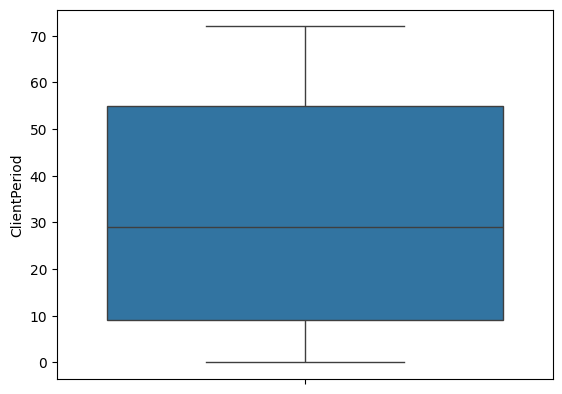

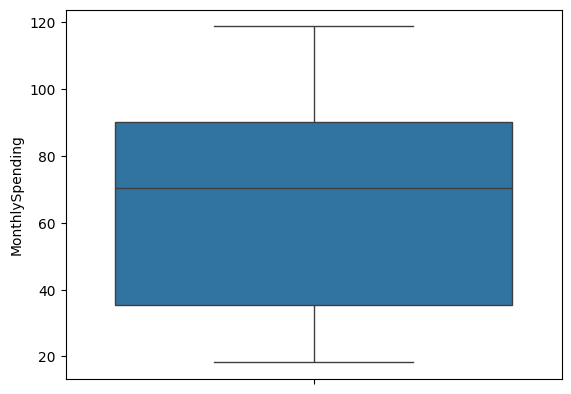

In [10]:
print(data[continuous_columns].isna().sum())

for c in continuous_columns:
  plt.figure()
  sns.boxplot(data[c])

Пропусков и выбросов нет

## Текстовые колонки

In [11]:
text_columns = [c for c in data.columns if data[c].dtype == 'object']
data[text_columns].describe()

,TotalSpent,Sex,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
count,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282
unique,4978,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
freq,9,2655,2705,3676,4761,2511,2341,2612,2332,2317,2604,2099,2081,2920,3148,1786


In [12]:
# TotalSpent -- вещественная колонка
data['TotalSpent'] = data['TotalSpent'].replace(' ', 0)
data['TotalSpent'] = data['TotalSpent'].astype(float)

continuous_columns.append('TotalSpent')
text_columns.remove('TotalSpent')

Разберемся с признаками с тремя значениями

In [13]:
tree_column = []

for column in text_columns:
    if data[column].nunique() == 3:
        tree_column.append(column)
        print(data[column].value_counts())
        print()

HasMultiplePhoneNumbers
No                  2511
Yes                 2250
No phone service     521
Name: count, dtype: int64

HasInternetService
Fiber optic    2341
DSL            1800
No             1141
Name: count, dtype: int64

HasOnlineSecurityService
No                     2612
Yes                    1529
No internet service    1141
Name: count, dtype: int64

HasOnlineBackup
No                     2332
Yes                    1809
No internet service    1141
Name: count, dtype: int64

HasDeviceProtection
No                     2317
Yes                    1824
No internet service    1141
Name: count, dtype: int64

HasTechSupportAccess
No                     2604
Yes                    1537
No internet service    1141
Name: count, dtype: int64

HasOnlineTV
No                     2099
Yes                    2042
No internet service    1141
Name: count, dtype: int64

HasMovieSubscription
No                     2081
Yes                    2060
No internet service    1141
Name: count, d

В колонках с тремя признаками есть везде значение "No internet service" и везде оно одинаковое. Из-за этого получим колонки, где признаки будут частично скоррелированы

Можно ли в таких колонках заменить 2 признака на их сумму? - Не стоит


In [14]:
from scipy.stats import chi2_contingency

for i in range(len(tree_column)):
    for j in range(i + 1, len(tree_column)):
        column1 = tree_column[i]
        column2 = tree_column[j]
        chi2, p, dof, expected = chi2_contingency(pd.crosstab(data[column1], data[column2]))
        if p >= 0.05:
            print(f"column1: {column1}, column2: {column2}, chi2: {chi2}, p: {p}")

Значит все признаки взяты из разных распределений

In [15]:
print(f'Численные колонки - {continuous_columns}')
print(f'Бинарные колонки - {binary_columns}')
print(f'Текстовые колонки - {text_columns}')

Численные колонки - ['ClientPeriod', 'MonthlySpending', 'TotalSpent']
Бинарные колонки - ['IsSeniorCitizen', 'Churn']
Текстовые колонки - ['Sex', 'HasPartner', 'HasChild', 'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod']


Текстовые колонки можно переделать в бинарные или категориальные

## Заполнение пропусков

Посмотрим на количество пропущенных значений

In [16]:
data.isna().sum()

,0
ClientPeriod,0
MonthlySpending,0
TotalSpent,0
Sex,0
IsSeniorCitizen,0
HasPartner,0
HasChild,0
HasPhoneService,0
HasMultiplePhoneNumbers,0
HasInternetService,0


Пропусков нет

## Feature Engineering

### Численные признаки

Посмотрим, какие новые признаки можно составить из имеющихся

In [17]:
data.columns

Index(['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'Sex',
       'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService',
       'HasMultiplePhoneNumbers', 'HasInternetService',
       'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection',
       'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription',
       'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod', 'Churn'],
      dtype='object')

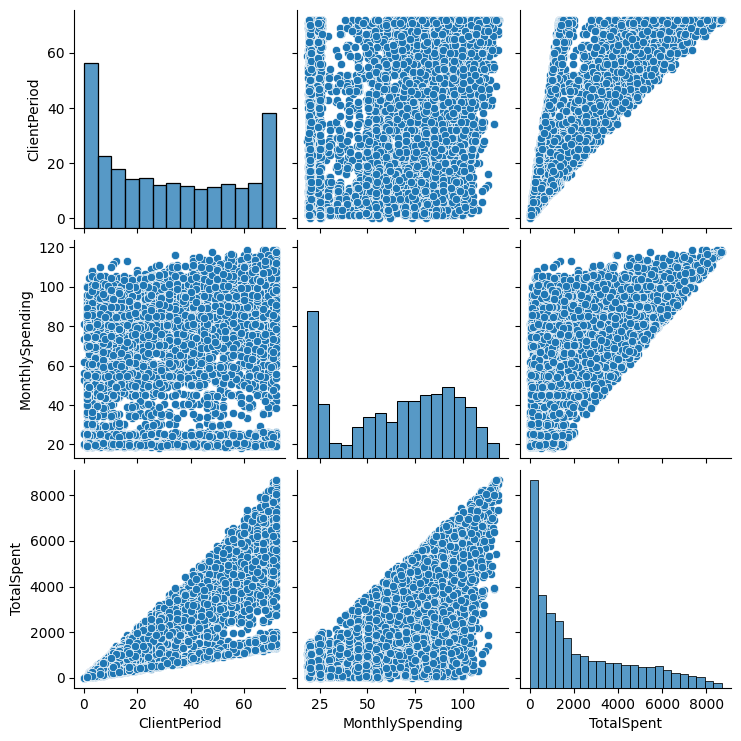

In [18]:
sns.pairplot(data[continuous_columns])

<Axes: >

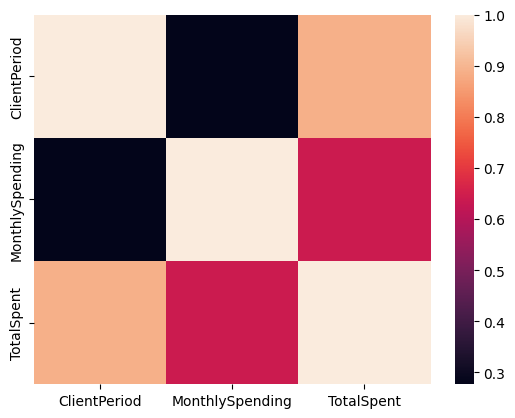

In [19]:
sns.heatmap(data[continuous_columns].corr(method='spearman'))

Видна взаимосвязь между TotalSpent и ClientPeriod, TotalSpent и MonthlySpending

In [20]:
from scipy.stats import spearmanr

print(spearmanr(data['TotalSpent'], data['ClientPeriod']))
print(spearmanr(data['TotalSpent'], data['MonthlySpending']))

SignificanceResult(statistic=0.8896653019175998, pvalue=0.0)
SignificanceResult(statistic=0.639684699111129, pvalue=0.0)


Обнаружилась статистически значимая корреляция между \\
TotalSpent - ClientPeriod \\
TotalSpent - MonthlySpending \\
Оценим взаимосвязь между признаками и целевой переменной

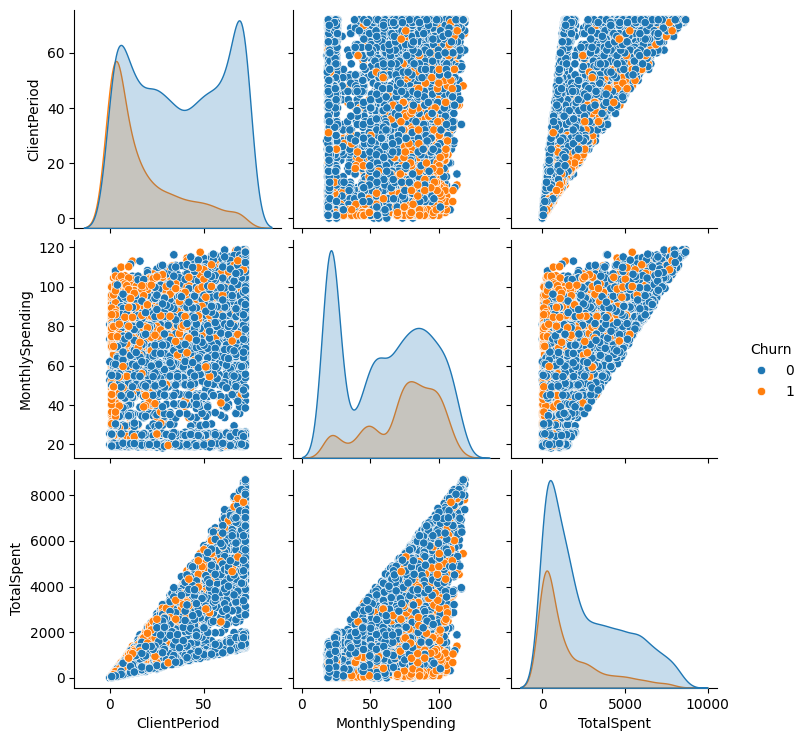

In [21]:
sns.pairplot(data=data[continuous_columns + ['Churn']], hue='Churn')

Можно заметить, что по TotalSpent мало что говорит о таргете. К тому же удаление этого признака уберет сразу 2 корреляции, поэтому удалим TotalSpent

In [22]:
data.drop(columns=['TotalSpent'], inplace=True)

### Категориальные признаки

In [23]:
data[binary_columns] = data[binary_columns].astype('str')
categorical_columns = text_columns + binary_columns

In [24]:
categorical_columns

['Sex',
 'HasPartner',
 'HasChild',
 'HasPhoneService',
 'HasMultiplePhoneNumbers',
 'HasInternetService',
 'HasOnlineSecurityService',
 'HasOnlineBackup',
 'HasDeviceProtection',
 'HasTechSupportAccess',
 'HasOnlineTV',
 'HasMovieSubscription',
 'HasContractPhone',
 'IsBillingPaperless',
 'PaymentMethod',
 'IsSeniorCitizen',
 'Churn']

Рассмотрим корреляции всех признаков друг с другом

In [25]:
from scipy.stats import chi2_contingency

for i in range(len(categorical_columns)):
    for j in range(i + 1, len(categorical_columns)):
        column1 = categorical_columns[i]
        column2 = categorical_columns[j]
        p_value = chi2_contingency(pd.crosstab(data[column1], data[column2])).pvalue
        if p_value < 0.05:
            print(f"column1: {column1}, column2: {column2}, p_value: {p_value}")

column1: HasPartner, column2: HasChild, p_value: 1.5766437531523178e-226
column1: HasPartner, column2: HasMultiplePhoneNumbers, p_value: 4.4121643123234043e-23
column1: HasPartner, column2: HasOnlineSecurityService, p_value: 6.558633195610773e-28
column1: HasPartner, column2: HasOnlineBackup, p_value: 1.7269302011470698e-25
column1: HasPartner, column2: HasDeviceProtection, p_value: 3.969132321517482e-33
column1: HasPartner, column2: HasTechSupportAccess, p_value: 2.2791307080340364e-20
column1: HasPartner, column2: HasOnlineTV, p_value: 2.281474583060465e-20
column1: HasPartner, column2: HasMovieSubscription, p_value: 1.1031902972507494e-20
column1: HasPartner, column2: HasContractPhone, p_value: 1.4847383753315184e-99
column1: HasPartner, column2: PaymentMethod, p_value: 1.4237209259490907e-29
column1: HasPartner, column2: Churn, p_value: 5.9150430666764906e-27
column1: HasChild, column2: HasInternetService, p_value: 5.732541635241689e-43
column1: HasChild, column2: HasOnlineSecurity

Рассмотрим признаки HasChild и HasPartner \\
Они сильно скоррелированы друг с другом и с другими признаками

<Axes: xlabel='HasChild', ylabel='count'>

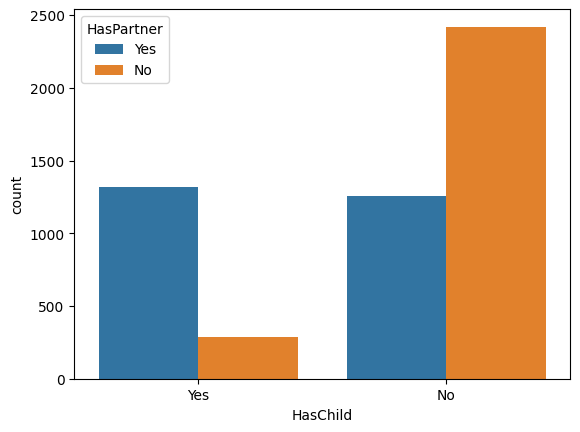

In [26]:
sns.countplot(data=data, x="HasChild", hue='HasPartner')

<Axes: xlabel='HasPartner', ylabel='count'>

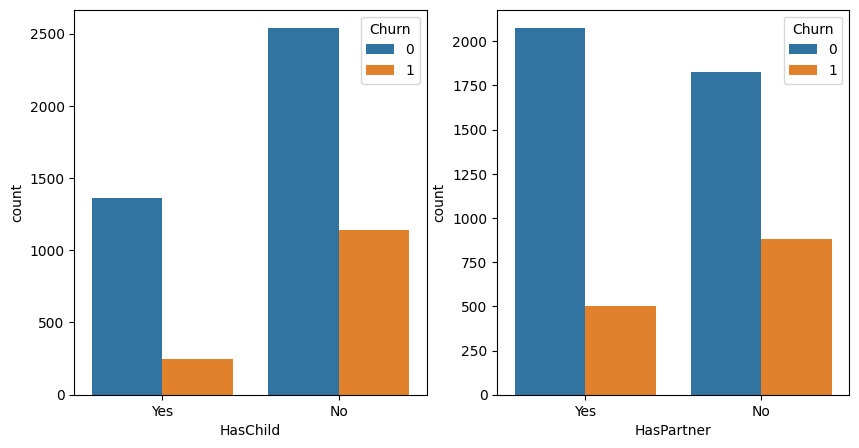

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(data=data, x='HasChild', hue='Churn', ax=axes[0])
sns.countplot(data=data, x='HasPartner', hue='Churn', ax=axes[1])

Удалим признак HasPartner

In [31]:
data.drop(columns=['HasPartner'], inplace=True)

# Boosting

In [33]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 5.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" an

In [34]:
from catboost import CatBoostClassifier, Pool
import lightgbm
import xgboost

from sklearn.model_selection import train_test_split

In [36]:
y = data['Churn']
X = data.drop(columns=['Churn'])

In [43]:
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

## CatBoost

In [44]:
X.dtypes

,0
ClientPeriod,int64
MonthlySpending,float64
Sex,object
IsSeniorCitizen,object
HasChild,object
HasPhoneService,object
HasMultiplePhoneNumbers,object
HasInternetService,object
HasOnlineSecurityService,object
HasOnlineBackup,object


In [45]:
cat_features = [column for column in X.columns if X[column].dtypes == 'object']
cat_features = np.array(cat_features)

In [ ]:
model = CatBoostClassifier()
model.fit(X_train, y_train, cat_features=cat_features)

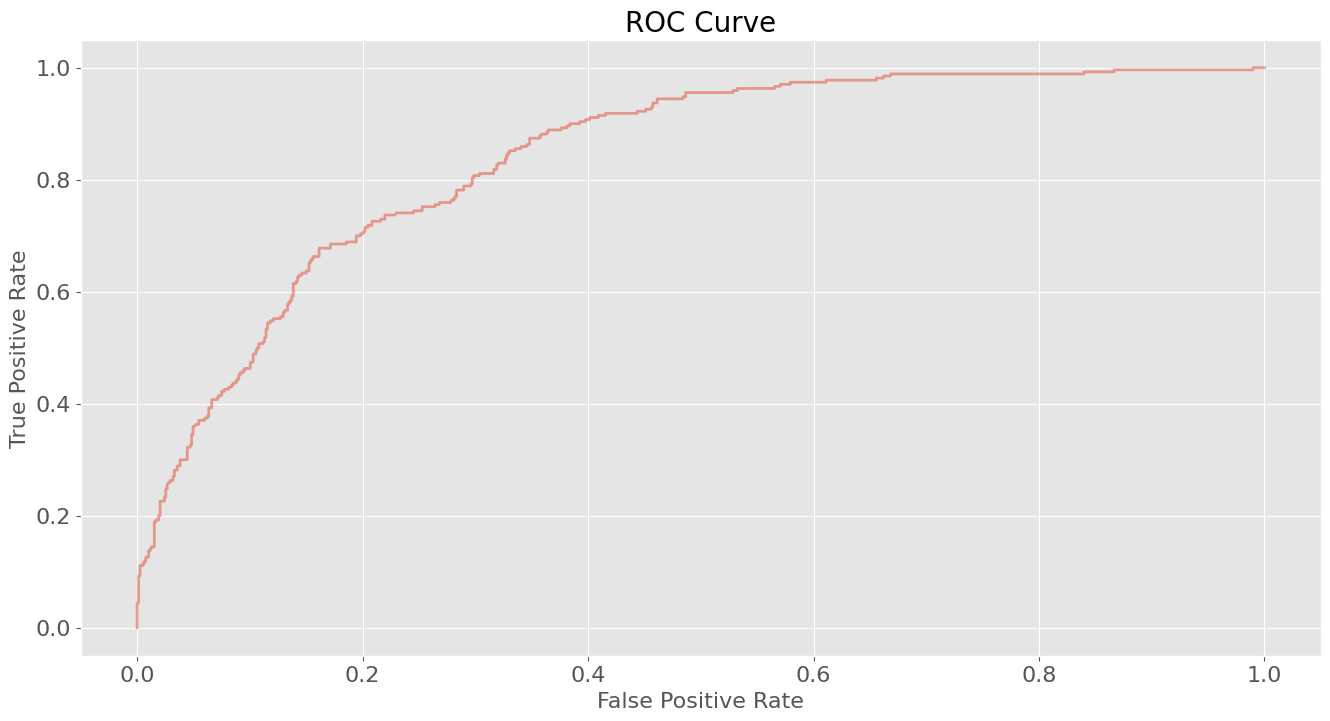

0.8402724834109842

In [47]:
import sklearn.metrics
import catboost
from catboost.utils import get_roc_curve

plt.style.use('ggplot')

dataset = Pool(X_test, y_test, cat_features=cat_features)
fpr, tpr, _ = get_roc_curve(model, dataset, plot=True)
auc = sklearn.metrics.auc(fpr, tpr)
auc

# Test data

In [48]:
test_data = pd.read_csv('test.csv')

In [49]:
test_data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.4,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.6,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


In [50]:
test_data['TotalSpent'] = test_data['TotalSpent'].replace(' ', 0)
test_data['TotalSpent'] = test_data['TotalSpent'].astype(float)

In [51]:
test_data.drop(columns=['TotalSpent'], inplace=True)

In [53]:
binary_columns = ['IsSeniorCitizen']
test_data[binary_columns] = test_data[binary_columns].astype('str')

In [54]:
test_data.drop(columns=['HasPartner'], inplace=True)

In [65]:
y_pred = model.predict_proba(test_data)

In [66]:
y_pred = [pred[1] for pred in y_pred]

In [67]:
y_pred

[0.028622963034567444,
 0.6960597404370047,
 0.6438774982664615,
 0.020018070251445794,
 0.003974188847830842,
 0.11143260571778585,
 0.40911625776847554,
 0.3415404198928153,
 0.029317594889326806,
 0.34454949173832955,
 0.1360043209127777,
 0.2240966722514378,
 0.30519444768715276,
 0.09012223679837983,
 0.01175678684351372,
 0.03355917929958914,
 0.11690316901877175,
 0.2573315880754721,
 0.011194203106662533,
 0.01478543753730027,
 0.13268860185591635,
 0.01005266133955717,
 0.8214923587076443,
 0.4273594078287769,
 0.11264439526042347,
 0.5027029719405054,
 0.09357218944121878,
 0.01938823277152312,
 0.041237093751804524,
 0.0030082084194323505,
 0.6707501772567802,
 0.2770210607669173,
 0.8012537939078571,
 0.504417585508358,
 0.09359513649399931,
 0.04960905621844185,
 0.5923888588032575,
 0.049235906543816564,
 0.1427811008491838,
 0.026173976918407605,
 0.2434077003264571,
 0.5741066443247349,
 0.44632001969414503,
 0.21794175281107453,
 0.3945222400954899,
 0.3672471445722154

In [71]:
submission = pd.DataFrame({'id': test_data.index, 'Churn': y_pred})
submission = submission.set_index('id')
submission.head()

,Churn
id,
0,0.028623
1,0.696060
2,0.643877
3,0.020018
4,0.003974


In [73]:
submission.to_csv('output.csv')